In [1]:
%env KERAS_BACKEND=tensorflow 

env: KERAS_BACKEND=tensorflow


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Keras functions
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Input
from keras.optimizers import SGD

# Keras dataset
from keras.datasets import mnist

# Keras utilis function
from keras.utils import np_utils

Using TensorFlow backend.
C:\Users\USER\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\USER\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\USER\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\USER\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [5]:
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)

In [6]:
print(x_train.shape, x_test.shape)

(60000, 784) (10000, 784)


In [7]:
y_train = np_utils.to_categorical(y_train, 10) #one-hot encoding
y_test = np_utils.to_categorical(y_test, 10)

**1.自定義的不具可訓練權重之神經網路層**

自定義神經網路層 (不具可訓練權重-ex：取平均)

具有可訓練重的自定義層牽扯到 TensorFlow 及 Python 類別的撰寫，可參考: https://keras.io/layers/writing-your-own-keras-layers/

首先需要引入 Lambda 這個函數，透過 Lambda 函數，可以將 Python 上的 function，包裝成 Keras 上的 layer。

此外，需要引進後端所使用的套件 (此處為 TensorFlow)，並使用裡面的運算進行 function 的撰寫。

In [8]:
from keras.layers.core import Lambda
from keras import backend as K #Keras 的「後端引擎」

透過 backend 來定義一個簡單的 function，作用是對輸入取平均

In [14]:
def average_function(inputs):
    return K.mean(inputs, axis=1) #用Keras Backend對變數(tensor)求平均 , axis=1為平均方向

In [15]:
#將一個 numpy array 送進這個函式為錯誤
average_function(np.array([1,3]))

AttributeError: 'numpy.dtype' object has no attribute 'base_dtype'

函式不接受 numpy array 的類型作為輸入，這是因為 TensorFlow 有自定義的類型。

**需透過 Lambda ，將上述函式包裝成一個神經網路層。**

In [18]:
average_layer = Lambda(average_function) #將運算包裝成layer，這邊可指定output shape

In [19]:
print(average_layer)

建構出一個將指定長度的資料取平均的神經網路。

In [21]:
inputSize = 4 #指定輸入長度為4維

x = Input(shape=(inputSize,))
y = average_layer(x)
average_model = Model(x,y)

In [22]:
average_model.summary() #無權重

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
lambda_2 (Lambda)            (None,)                   0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [25]:
np.array([[1,2,3,4]]).shape #一筆4維的向量
#在keras以batch為單位輸入(batch = 1)

(1, 4)

In [26]:
average_model.predict(np.array([[1,2,3,4]]))

array([2.5], dtype=float32)

In [27]:
average_model.predict(np.array([[1,2,3,4],
                               [1,2,5,9]]))

array([2.5 , 4.25], dtype=float32)

**2.具抽樣功能的神經網路層**

輸入為 $(\mu, s)$ ，$\mu=(\mu_1,\cdots,\mu_n)$ 和 $s=(s_1,\cdots,s_n)$ 各自為 $n$ 維向量。

神經網路層輸出為服從 $N(\mu, e^{s}I_n)$ 的 $n$ 維向量，換言之，所建構的神經網路其實是一個抽樣函數。

** 由於神經網路的輸入輸出經常沒有限制，為了讓 $s$ 具有變異數的非負特性，考慮 $e^{s}$ 作為變異數(非負數)；換言之，$s$ 為 log-variance。

假設想進行抽樣的維度為 sampling_dim，則一個具抽樣函數功能的神經網路可由下述方式建構。

In [15]:
sampling_dim = 2

def sampling(args):
    z_mean, z_log_var = args #輸入的向量變成mean和variance
    epsilon = K.random_normal(shape=(sampling_dim,),mean=0., stddev=1) #二維的標準常態分配
    return z_mean + K.exp(z_log_var / 2) * epsilon #如下公式，得出服從常態分配的值，除二是開根號意思

這裡使用到常態分配的線性特性來定義函數，亦即

$$X\sim N(0, 1)\Rightarrow \mu+\sigma X\sim N(\mu, \sigma^2)$$

In [16]:
#將運算包裝成layer，這邊希望兩個兩維進去，一個兩維出來
sample_layer = Lambda(sampling, output_shape=(sampling_dim,))

In [17]:
m = Input(shape=(sampling_dim,))
s = Input(shape=(sampling_dim,))

z = sample_layer([m,s]) #Lambda 可接受 list，比較像函式定義的東西，這邊的z是服從常態分配的值

sample_model = Model([m,s] , z) #Model(x,y)

In [18]:
sample_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 2)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2)            0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 2)            0           input_1[0][0]                    
                                                                 input_2[0][0]                    
Total params: 0
Trainable params: 0
Non-trainable params: 0
__________________________________________________________________________________________________


In [40]:
#隨機生成mean var
test_mean = np.random.randint(10, size = sampling_dim).reshape(1,2)
test_log_var = np.array([[0,0]]) #取epsilon變 1

print('平均為 (%d, %d)' %(test_mean[0][0], test_mean[0][1]))

平均為 (7, 5)


透過下面的指令，每次可以抽樣出一服從上述要求常態分配之隨機向量

In [41]:
sample_model.predict([test_mean, test_log_var])

array([[9.203978 , 5.9510236]], dtype=float32)

和 Numpy 上的抽樣函數進行比較

In [29]:
num_of_samples = 100

In [30]:
np_sample = np.random.multivariate_normal(test_mean[0], np.identity(2),
                                          size = num_of_samples) #得到100個點

In [43]:
np_sample

array([[ 3.30895419,  8.68270861],
       [ 5.18679229, 10.84715094],
       [ 3.7506866 , 10.10014645],
       [ 3.81065712, 10.50917616],
       [ 3.07652825,  8.92274666],
       [ 4.22418775, 10.76595451],
       [ 5.05000311,  7.80787424],
       [ 3.0488507 ,  8.87904292],
       [ 6.02612576,  8.45934205],
       [ 3.60284234,  9.1162625 ],
       [ 2.19235968,  8.86562778],
       [ 4.35344905,  7.93694942],
       [ 4.32922576, 10.16191056],
       [ 5.91214204,  8.84661494],
       [ 3.45965839,  8.49375681],
       [ 4.16915475,  8.17277348],
       [ 5.59127695, 10.16256918],
       [ 5.0039162 ,  7.6641071 ],
       [ 1.06717579,  9.06314757],
       [ 3.42496556,  7.83297245],
       [ 5.3621822 ,  7.38383523],
       [ 3.78987345,  8.55932696],
       [ 5.13512357,  7.68409893],
       [ 5.12050871,  9.94695127],
       [ 4.99509304,  9.35926542],
       [ 4.15677958,  8.79711615],
       [ 3.51582152,  9.65148389],
       [ 2.44624318, 10.83841391],
       [ 2.16345173,

In [31]:
kears_sample = np.zeros((num_of_samples, 2)) #100筆2維向量，以下迴圈輸入服從規定常態分配的向量
for i in range(num_of_samples):
    kears_sample[i] = sample_model.predict([test_mean, test_log_var])

In [42]:
kears_sample

array([[ 5.0580492 ,  8.52884293],
       [ 2.05793047,  9.77625179],
       [ 5.24484634,  9.74450779],
       [ 4.39279413,  7.8901186 ],
       [ 5.90641069,  9.00927162],
       [ 5.0019393 ,  7.02149963],
       [ 3.94315434, 10.76341629],
       [ 4.63526964,  9.58420277],
       [ 3.33372331,  7.56639004],
       [ 4.09860849,  7.75074768],
       [ 3.97260571,  8.92345047],
       [ 4.47688293, 10.1596508 ],
       [ 4.77077961, 10.08753777],
       [ 5.68126535,  8.36770153],
       [ 3.98388577,  8.53683758],
       [ 3.68201184,  8.12078857],
       [ 2.95955229,  8.02174568],
       [ 4.82679272,  9.70175934],
       [ 4.06302261,  6.40324545],
       [ 4.04698229, 10.06652641],
       [ 3.74326777,  8.68317413],
       [ 2.08623028,  9.79720592],
       [ 2.36143398,  8.72496414],
       [ 5.48997831, 10.2927351 ],
       [ 3.61952734,  9.16607475],
       [ 4.61282635,  7.96361685],
       [ 5.26498795, 11.20587349],
       [ 4.76329994, 10.58777142],
       [ 3.65003777,

Text(0.5, 1.0, 'Normal Random Samples using Keras/Numpy')

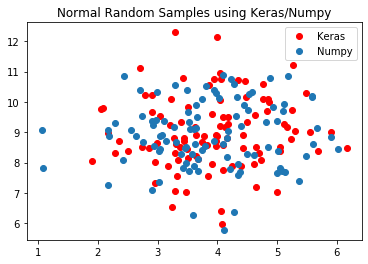

In [32]:
plt.plot(kears_sample[:, 0], kears_sample[:, 1], 'ro')
plt.plot(np_sample[:, 0], np_sample[:, 1], 'o')
plt.legend(['Keras', 'Numpy'])
plt.title('Normal Random Samples using Keras/Numpy')

Variational Autoencoder (VAE) 是一個重要的非監督式學習模型，具體應用的場合為特徵抽取/資料壓縮及還原，為影像處理中常見的模型之一。

在建立 VAE中，需要的兩個重要技巧:

- 分歧-合併
- 自定義函數 (抽樣函數)